In [1]:
!pip install scikit-learn --upgrade

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk

# Bag of words and Tokenizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF
from sklearn.preprocessing import label_binarize

# Classification methods
from sklearn.naive_bayes import MultinomialNB   # Naive Bayes
from sklearn.tree import DecisionTreeClassifier  # Decision Tree
from sklearn.neural_network import MLPClassifier # Multi-Layer Perceptron
from sklearn.neighbors import KNeighborsClassifier # KNN


# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

### Training data

In [2]:
data_path = '/content/data/'
rdfTrain = pd.read_csv(data_path + 'train.tsv', sep = '\t', header = None, names = ['text', 'label', 'id'])
rdfTrain.head()

,text,label,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


### Dev data

In [3]:
# validation set
data_path = '/content/data/'
rdfDev = pd.read_csv(data_path + 'dev.tsv', sep = '\t', header = None, names = ['text', 'label', 'id'])
rdfDev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5426 entries, 0 to 5425
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5426 non-null   object
 1   label   5426 non-null   object
 2   id      5426 non-null   object
dtypes: object(3)
memory usage: 127.3+ KB


#### Neutral/Non-neutral

In [4]:
def label_neutral(row):
    if row['label'] == '27':
        return 1
    else:
        return 0

#### 3 categories: Positive, negative and Neutral

In [5]:
pos_labels = ['admiration','approval', 'amusement', 'caring', 'desire',
              'excitement', 'gratitude', 'joy', 'love','optimism', 'pride', 'relief']
neg_labels = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust',
              'embarrassment','fear', 'grief', 'nervousness', 'remorse', 'sadness']
ambi_labels = ['confusion', 'curiosity', 'realization', 'surprise']

In [6]:
emotion_to_idx = {
    'admiration' : '0',
    'amusement' : '1',
    'anger' : '2',
    'annoyance' : '3',
    'approval' : '4',
    'caring' : '5',
    'confusion' : '6',
    'curiosity' : '7',
    'desire' : '8',
    'disappointment' : '9',
    'disapproval' : '10',
    'disgust' : '11',
    'embarrassment' : '12',
    'excitement' : '13',
    'fear' : '14',
    'gratitude' : '15',
    'grief' : '16',
    'joy' : '17',
    'love' : '18',
    'nervousness' : '19',
    'optimism' : '20',
    'pride' : '21',
    'realization' : '22',
    'relief' : '23',
    'remorse' : '24',
    'sadness' : '25',
    'surprise' : '26',
    'neutral' : '27'
}

In [7]:
label_to_emotion = {j:i for i, j in emotion_to_idx.items()}
label_to_emotion

{'0': 'admiration',
 '1': 'amusement',
 '2': 'anger',
 '3': 'annoyance',
 '4': 'approval',
 '5': 'caring',
 '6': 'confusion',
 '7': 'curiosity',
 '8': 'desire',
 '9': 'disappointment',
 '10': 'disapproval',
 '11': 'disgust',
 '12': 'embarrassment',
 '13': 'excitement',
 '14': 'fear',
 '15': 'gratitude',
 '16': 'grief',
 '17': 'joy',
 '18': 'love',
 '19': 'nervousness',
 '20': 'optimism',
 '21': 'pride',
 '22': 'realization',
 '23': 'relief',
 '24': 'remorse',
 '25': 'sadness',
 '26': 'surprise',
 '27': 'neutral'}

In [8]:
def label_pos_neg_neutral(row):
    '''
    Sentiment Analysis label:
    0 - Negative
    1 - Positive
    2 - Neutral/Ambigous
    '''
    sentiment = [0, 0, 0]
    labels = row['label'].split(",")
    for l in labels:
        label = label_to_emotion[l]
        if label in pos_labels:
            sentiment[1] += 1
        elif label in neg_labels:
            sentiment[0] += 1
        else:
            sentiment[2] += 1
    return np.argmax(np.array(sentiment))

In [9]:
anger_list = [ "anger", "annoyance", "disapproval", "disgust"]
fear_list = ["fear", "nervousness"]
joy_list = ["joy", "amusement", "approval", "excitement", "gratitude","love", "optimism", "relief", "pride", "admiration", "desire", "caring"]
sadness_list = ["sadness", "disappointment", "embarrassment", "grief", "remorse"]
surprise_list = ["surprise", "realization", "confusion", "curiosity"]

In [10]:
def label_emotion_group(row):
    '''
    Groupping Emotion Label:
    0 - Anger, 1 - Fear, 2- Joy,
    3 - Sadness, 4 - Surprise, 5 - Neutral/Ambigous
    '''
    sentiment = [0]*6
    labels = row['label'].split(",")
    for l in labels:
        if l == '27':
            return 5 # Neutral

        label = label_to_emotion[l]
        if label in anger_list:
            sentiment[0] += 1
        elif label in fear_list:
            sentiment[1] += 1
        elif label in joy_list:
            sentiment[2] += 1
        elif label in sadness_list:
            sentiment[3] += 1
        elif label in surprise_list:
            sentiment[4] += 1
        else:
            sentiment[5] += 1
    return np.argmax(np.array(sentiment))

In [11]:
def transformData(rdfTrain, rdfDev, n_categories = 2):

    dfTrain, dfDev = rdfTrain, rdfDev
    if n_categories == 2:
        dfTrain["class_label"] = dfTrain.apply(lambda row: label_neutral(row), axis = 1)
        dfDev["class_label"] = dfDev.apply(lambda row: label_neutral(row), axis = 1)

    if n_categories == 3:
        dfTrain["class_label"] = dfTrain.apply(lambda row: label_pos_neg_neutral(row), axis = 1)
        dfDev["class_label"] = dfDev.apply(lambda row: label_pos_neg_neutral(row), axis = 1)

    if n_categories == 6:
        dfTrain["class_label"] = dfTrain.apply(lambda row: label_emotion_group(row), axis = 1)
        dfDev["class_label"] = dfDev.apply(lambda row: label_emotion_group(row), axis = 1)

    print("Training distribution: ", dfTrain.class_label.value_counts())
    print("Dev data distribution: ", dfDev.class_label.value_counts())

    return dfTrain, dfDev

#### Splitting data

In [12]:
def splitData(trainFeatures, devFeatures, dfTrain, dfDev):
    xTrain, yTrain = trainFeatures, dfTrain['class_label']
    xDev, yDev = devFeatures, dfDev['class_label']

    print("Dev : ", xDev.shape, yDev.shape)
    print("Train : ", xTrain.shape, yTrain.shape)

    return xTrain, yTrain, xDev, yDev

#### Feature Generation - TFID & Bag of words

In [13]:
def featureGeneration(dfTrain, dfDev, method = 'BOW'):
    if method == 'BOW':
        #tokenizer to remove unwanted elements from out data like symbols and numbers
#         token = RegexpTokenizer(r'[a-zA-Z0-9]+')
        token = TweetTokenizer(strip_handles=True, reduce_len=True)
        cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), tokenizer = token.tokenize)
        trainFeatures = cv.fit_transform(dfTrain['text'])
        devFeatures = cv.transform(dfDev['text'])

    if method == 'TF-IDF':
        tf = TfidfVectorizer()
        trainFeatures = tf.fit_transform(dfTrain['text'])
        devFeatures = tf.transform(dfDev['text'])

    return trainFeatures, devFeatures

#### Modelling - Naive Bayes

In [14]:
def naiveBayes(xTrain, yTrain, xDev, yDev):
    # Model Generation Using Multinomial Naive Bayes
    clf = MultinomialNB().fit(xTrain, yTrain)
    predicted= clf.predict(xDev)
    print("MultinomialNB Accuracy:", metrics.accuracy_score(yDev, predicted))

In [27]:
def model(xTrain, yTrain, xDev, yDev, method = 'Naive Bayes'):

    num_classes = len(yTrain.unique())
    print("Num classes: ", num_classes)

    if method == 'Naive Bayes':
        clf = MultinomialNB()

    if method == 'Decision Trees':
        clf = DecisionTreeClassifier()

    if method == 'MLP':
        clf = MLPClassifier()

    if method == 'KNN':
        clf = KNeighborsClassifier(n_neighbors=5)

    clf = clf.fit(xTrain, yTrain)
    predicted= clf.predict(xDev)

#   Evaluation metrics

    Y_test = label_binarize(yDev, classes=[0, 1, 2])
    Y_score = label_binarize(predicted, classes=[0, 1, 2])

    acc = metrics.accuracy_score(Y_test, Y_score)
    precision = metrics.precision_score(Y_test, Y_score, average='macro')
    recall = metrics.recall_score(Y_test, Y_score,average='macro' )
    roc_auc = metrics.roc_auc_score(Y_test, Y_score,average='macro')

    f1 = metrics.f1_score(Y_test, Y_score, average='macro')
    confusion_matrix = metrics.confusion_matrix(yDev, predicted)

    np_Y_test, np_Y_score = np.array(Y_test), np.array(Y_score)
    idx = np.where(np_Y_test < 2)
    np_Y_test = np_Y_test[idx]
    np_Y_score = np_Y_score[idx]
    print(np_Y_test.shape, np_Y_score.shape)
    fpr, tpr, thresholds = metrics.roc_curve(np_Y_test, np_Y_score)
    print(str(acc) + "\t" + str(precision) + "\t" + str(recall) + "\t" + str(f1) + "\t" + str(roc_auc))
    print(confusion_matrix)

    #     print("Accuracy:", acc)
    #     print("Precision:", precision)
    #     print("Recall:", recall)
    #     print("ROC AUC: ", roc_auc)
    #     print("f1-score:", f1)
    #     print("Confusion Matrix: \n", confusion_matrix)
    return clf, acc, precision, recall, roc_auc, f1, confusion_matrix, fpr, tpr, thresholds


#### Testing

In [16]:
dfTrain, dfDev = transformData(rdfTrain, rdfDev, n_categories = 3)

Training distribution:  class_label
2    17021
1    16628
0     9761
Name: count, dtype: int64
Dev data distribution:  class_label
1    2106
2    2096
0    1224
Name: count, dtype: int64


In [17]:
trainFeatures, devFeatures = featureGeneration(dfTrain, dfDev, method = 'BOW')
xTrain, yTrain, xDev, yDev = splitData(trainFeatures, devFeatures, dfTrain, dfDev)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Dev :  (5426, 27774) (5426,)
Train :  (43410, 27774) (43410,)


In [18]:
clf = model(xTrain, yTrain, xDev, yDev, method = 'Naive Bayes')

Num classes:  3
(16278,) (16278,)
0.6444894950239587	0.6350129472893912	0.6132510170796605	0.6174241641027123	0.7134700171986642
[[ 515  273  436]
 [ 107 1637  362]
 [ 231  520 1345]]


In [19]:
clf = model(xTrain, yTrain, xDev, yDev, method = 'Decision Trees')

Num classes:  3
(16278,) (16278,)
0.6196092886103944	0.6023071536751834	0.5957643257168029	0.598113466714508	0.6999566121951984
[[ 549  242  433]
 [ 174 1464  468]
 [ 353  394 1349]]


In [20]:
clf = model(xTrain, yTrain, xDev, yDev, method = 'MLP')

Num classes:  3
(16278,) (16278,)
0.6452266863251014	0.6306181800425126	0.6236179198341799	0.626287122517113	0.7205391762444489
[[ 600  195  429]
 [ 170 1504  432]
 [ 327  372 1397]]


In [21]:
clf = model(xTrain, yTrain, xDev, yDev, method = 'KNN')

Num classes:  3
(16278,) (16278,)
0.5333579063767048	0.5179227356682982	0.49409991808210635	0.4909140688000709	0.6251523304782824
[[ 306  226  692]
 [ 220 1074  812]
 [ 253  329 1514]]


### Evaluation

In [22]:
acc_list = []
precision_list = []
recall_list = []
f1_list = []
# confusion_matrix =
roc_auc_list = []

In [23]:
yTrain

,class_label
0,2
1,2
2,0
3,0
4,0
...,...
43405,1
43406,2
43407,0
43408,1


In [28]:
clf, acc, precision, recall, roc_auc, f1, confusion_matrix, fpr, tpr, thresholds = model(xTrain, yTrain, xDev, yDev, method = 'KNN')


Num classes:  3
(16278,) (16278,)
0.5333579063767048	0.5179227356682982	0.49409991808210635	0.4909140688000709	0.6251523304782824
[[ 306  226  692]
 [ 220 1074  812]
 [ 253  329 1514]]


In [29]:
fpr, tpr, thresholds

(array([0.        , 0.23332105, 1.        ]),
 array([0.        , 0.53335791, 1.        ]),
 array([inf,  1.,  0.]))

In [30]:
acc_list.append(acc)
precision_list.append(precision)
recall_list.append(recall)
roc_auc_list.append(roc_auc)
f1_list.append(f1)

In [32]:
clf, acc, precision, recall, roc_auc, f1, confusion_matrix, *_ = model(xTrain, yTrain, xDev, yDev, method='Naive Bayes')
print(confusion_matrix)


Num classes:  3
(16278,) (16278,)
0.6444894950239587	0.6350129472893912	0.6132510170796605	0.6174241641027123	0.7134700171986642
[[ 515  273  436]
 [ 107 1637  362]
 [ 231  520 1345]]
[[ 515  273  436]
 [ 107 1637  362]
 [ 231  520 1345]]


In [33]:
acc_list.append(acc)
precision_list.append(precision)
recall_list.append(recall)
roc_auc_list.append(roc_auc)
f1_list.append(f1)

In [35]:
clf, acc, precision, recall, roc_auc, f1, confusion_matrix, *_= model(xTrain, yTrain, xDev, yDev, method = 'Decision Trees')

Num classes:  3
(16278,) (16278,)
0.6170291190563951	0.5996862761755074	0.5938785119827129	0.596038445018212	0.6984158133335229
[[ 552  239  433]
 [ 178 1463  465]
 [ 359  404 1333]]


In [36]:
acc_list.append(acc)
precision_list.append(precision)
recall_list.append(recall)
roc_auc_list.append(roc_auc)
f1_list.append(f1)

In [37]:
clf, acc, precision, recall, roc_auc, f1, confusion_matrix, *_ = model(xTrain, yTrain, xDev, yDev, method = 'MLP')

Num classes:  3
(16278,) (16278,)
0.6516771102100996	0.6380073370006115	0.6320074677761901	0.6344344574735692	0.7264011032530099
[[ 625  202  397]
 [ 163 1516  427]
 [ 326  375 1395]]


In [38]:
acc_list.append(acc)
precision_list.append(precision)
recall_list.append(recall)
roc_auc_list.append(roc_auc)
f1_list.append(f1)

In [39]:
print(acc_list)
print(precision_list)
print(recall_list)
print(roc_auc_list)
print(f1_list)

[0.5333579063767048, 0.6444894950239587, 0.6170291190563951, 0.6516771102100996]
[0.5179227356682982, 0.6350129472893912, 0.5996862761755074, 0.6380073370006115]
[0.49409991808210635, 0.6132510170796605, 0.5938785119827129, 0.6320074677761901]
[0.6251523304782824, 0.7134700171986642, 0.6984158133335229, 0.7264011032530099]
[0.4909140688000709, 0.6174241641027123, 0.596038445018212, 0.6344344574735692]


In [40]:
xrange = [1, 2, 3, 4]
xlabels = ['KNN', 'Naive Bayes', 'Decision Tree', 'MLP']

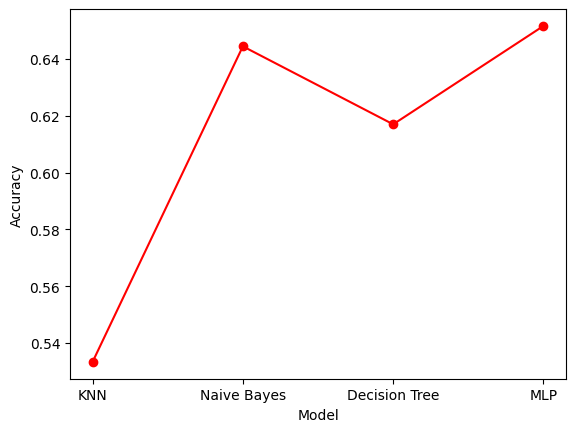

In [41]:
plt.plot(xrange, acc_list, '-ro')
plt.xticks(xrange, labels = xlabels)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()

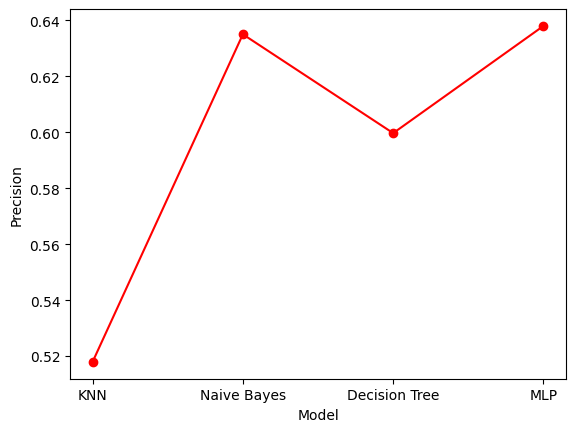

In [42]:
plt.plot(xrange, precision_list, '-ro')
plt.xticks(xrange, labels = xlabels)
plt.xlabel("Model")
plt.ylabel("Precision")
plt.show()

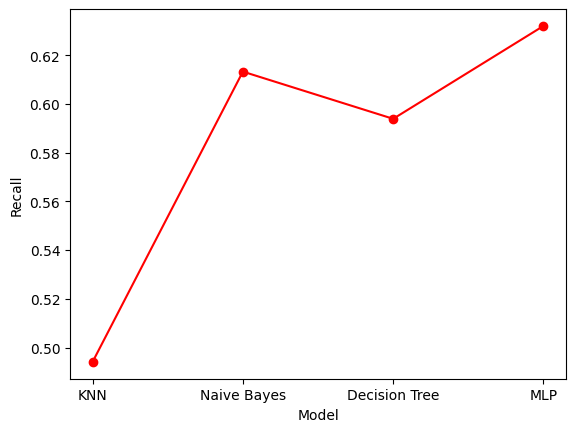

In [43]:
plt.plot(xrange, recall_list, '-ro')
plt.xticks(xrange, labels = xlabels)
plt.xlabel("Model")
plt.ylabel("Recall")
plt.show()

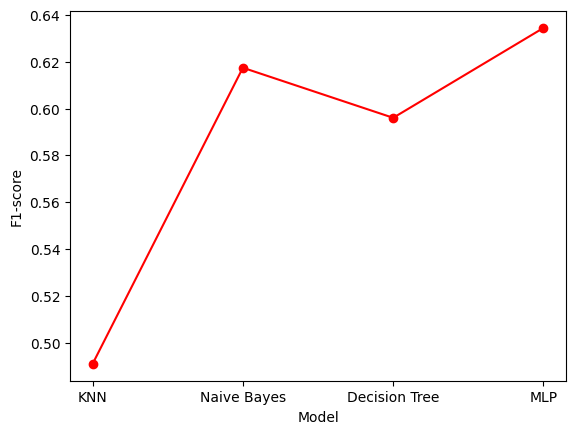

In [44]:
plt.plot(xrange, f1_list, '-ro')
plt.xticks(xrange, labels = xlabels)
plt.xlabel("Model")
plt.ylabel("F1-score")
plt.show()

In [45]:
acc_list = [0.5350165868042757, 0.6444894950239587, 0.6098415038702544, 0.6514928123848138]
precision_list = [0.5184507479851588, 0.634880350293078, 0.590477096183133, 0.6357280239000141]
recall_list = [0.49495868427041406, 0.6132510170796605, 0.5838293733288246, 0.6333016759693156]
f1_list = [0.625990618431603, 0.7134802528433225, 0.6915240415219852, 0.7273679972856814]
roc_auc_list = [0.49146066340947286, 0.6173914339319024, 0.5860548723771274, 0.6343716809302775]

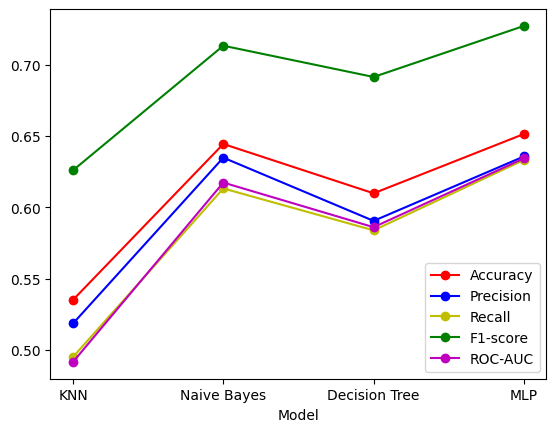

In [46]:
# %matplotlib tk
plt.plot(xrange, acc_list, '-ro', label = "Accuracy")
plt.plot(xrange, precision_list, '-bo', label = "Precision")
plt.plot(xrange, recall_list, '-yo', label = "Recall")
plt.plot(xrange, f1_list, '-go', label = "F1-score")
plt.plot(xrange, roc_auc_list, '-mo', label = "ROC-AUC")
plt.xticks(xrange, labels = xlabels)
plt.xlabel("Model")
plt.legend()
plt.show()